<a href="https://colab.research.google.com/github/eduardez/Machine-Learning-ESI/blob/master/Dengue_LSTM_LineaBase.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%matplotlib inline

from __future__ import print_function
from __future__ import division

import pandas as pd
import numpy as np
np.set_printoptions(threshold=np.inf)

from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
import statsmodels.api as sm

#LSTM
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

from numpy import concatenate

import math
from statsmodels.tools import eval_measures




/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
# load the provided data
train_features_raw = pd.read_csv('https://raw.githubusercontent.com/eduardez/Machine-Learning-ESI/master/dengue_features_train.csv?token=ANLXPWLSBAHLW7JMOAVKME276B3UC',
                             index_col=[0,1,2])

train_labels_raw = pd.read_csv('https://raw.githubusercontent.com/eduardez/Machine-Learning-ESI/master/dengue_labels_train.csv?token=ANLXPWJ55GZEX4IWHXQA3IS76B3WQ',
                           index_col=[0,1,2])

features_test_raw = pd.read_csv('https://raw.githubusercontent.com/eduardez/Machine-Learning-ESI/master/dengue_features_test.csv?token=ANLXPWOAY3AS6JWDRSIMHI276CDY6',
                           index_col=[0,1,2])

submission = pd.read_csv('https://raw.githubusercontent.com/eduardez/Machine-Learning-ESI/master/submission_format.csv?token=ANLXPWPCMTBVVHBSCUFJB5C76CEHE',
                           index_col=[0,1,2])

In [3]:
def shift(sj_train_features, iq_train_features, label):
  sj_train_features['reanalysis_precip_amt_kg_per_m2_2w_ago'] = sj_train_features.reanalysis_precip_amt_kg_per_m2.shift(periods = 2, fill_value = 0)
  sj_train_features['precipitation_amt_mm_2w_ago'] = sj_train_features.precipitation_amt_mm.shift(periods = 2, fill_value = 0)
  sj_train_features['station_precip_mm_m2_2w_ago'] = sj_train_features.station_precip_mm.shift(periods = 2, fill_value = 0)
  sj_train_features['reanalysis_specific_humidity_g_per_kg_6w_ago'] = sj_train_features.reanalysis_specific_humidity_g_per_kg.shift(periods = 6, fill_value = 0)
  sj_train_features['station_max_temp_c_6w_ago'] = sj_train_features.station_max_temp_c.shift(periods = 6, fill_value = 0)
  sj_train_features['station_min_temp_c_7w_ago'] = sj_train_features.station_min_temp_c.shift(periods = 7, fill_value = 0)
  sj_train_features['station_avg_temp_c_7w_ago'] = sj_train_features.station_avg_temp_c.shift(periods = 7, fill_value = 0)
  sj_train_features['ndvi_nw_11w_ago'] = sj_train_features.ndvi_nw.shift(periods = 11, fill_value = 0)
  sj_train_features['ndvi_ne_15w_ago'] = sj_train_features.ndvi_ne.shift(periods = 15, fill_value = 0)
  sj_train_features['station_diur_temp_rng_c_18w_ago'] = sj_train_features.station_diur_temp_rng_c.shift(periods = 18, fill_value = 0)
  if label:
    sj_total_cases = sj_train_features.pop('total_cases')
    sj_train_features.insert(loc=0, column='total_cases', value=sj_total_cases)
  

  iq_train_features['precipitation_amt_mm_3w_ago'] = iq_train_features.precipitation_amt_mm.shift(periods = 3, fill_value = 0)
  iq_train_features['station_precip_mm_3w_ago'] = iq_train_features.station_precip_mm.shift(periods = 3, fill_value = 0)
  iq_train_features['station_diur_temp_rng_c_10w_ago'] = iq_train_features.station_diur_temp_rng_c.shift(periods = 10, fill_value = 0)
  iq_train_features['ndvi_sw_11w_ago'] = iq_train_features.ndvi_sw.shift(periods = 11, fill_value = 0)
  iq_train_features['ndvi_ne_11w_ago'] = iq_train_features.ndvi_ne.shift(periods = 11, fill_value = 0)
  iq_train_features['ndvi_nw_11w_ago'] = iq_train_features.ndvi_nw.shift(periods = 11, fill_value = 0)
  iq_train_features['ndvi_se_14w_ago'] = iq_train_features.ndvi_se.shift(periods = 14, fill_value = 0)
  iq_train_features['reanalysis_tdtr_k_15w_ago'] = iq_train_features.reanalysis_tdtr_k.shift(periods = 15, fill_value = 0)
  iq_train_features['reanalysis_air_temp_k_16w_ago'] = iq_train_features.reanalysis_air_temp_k.shift(periods = 16, fill_value = 0)
  iq_train_features['reanalysis_avg_temp_k_16w_ago'] = iq_train_features.reanalysis_avg_temp_k.shift(periods = 16, fill_value = 0)
  iq_train_features['reanalysis_max_air_temp_k_3w_ago'] = iq_train_features.reanalysis_max_air_temp_k.shift(periods = 16, fill_value = 0)
  if label:
    iq_total_cases = iq_train_features.pop('total_cases')
    iq_train_features.insert(loc=0, column='total_cases', value=iq_total_cases)

  return sj_train_features, iq_train_features

In [4]:
def transformar_fecha (df):
  df['formatted_date'] = df.year * 1000 + df.weekofyear * 10 + 0

  df['date'] = pd.to_datetime(df['formatted_date'], format='%Y%W%w')
  df.drop('year', axis=1, inplace=True)
  df.drop('weekofyear', axis=1, inplace=True)
  df.drop('formatted_date', axis=1, inplace=True)
  df.set_index(['city','date'], inplace=True)
  return df

In [5]:
def preprocess_data(data_path, labels_path=None, reduc_features=False):
    # load data and set index to city, year, weekofyear
    df = pd.read_csv(data_path, index_col=[0, 1, 2])

    #we remove those features we high correlation between them
    #df.drop('week_start_date', axis=1, inplace=True)
    #df.drop("reanalysis_sat_precip_amt_mm", axis = 1, inplace = True)
    
    # fill missing values
    df.fillna(method='ffill', inplace=True)

    # add labels to dataframe
    if labels_path:
        labels = pd.read_csv(labels_path, index_col=[0, 1, 2])
        df = pd.concat([df, labels], axis=1)
  
    # separate san juan and iquitos
    sj_train = df.loc['sj']
    iq_train = df.loc['iq']

    # add new feautures with shifts
    
    sj_train, iq_train = shift(sj_train, iq_train, labels_path)
    
    # select features we want
    if reduc_features:
      sj_features = ['reanalysis_specific_humidity_g_per_kg_6w_ago',
                  'station_min_temp_c_7w_ago',
                  'station_avg_temp_c_7w_ago',
                  'reanalysis_specific_humidity_g_per_kg',
                  'station_max_temp_c_6w_ago',
                  'reanalysis_dew_point_temp_k']

      iq_features = ['reanalysis_specific_humidity_g_per_kg',
                    'reanalysis_dew_point_temp_k',
                    'reanalysis_min_air_temp_k',
                    'station_min_temp_c','reanalysis_tdtr_k_15w_ago','ndvi_sw_11w_ago']
      if labels_path:
        sj_features.append('total_cases')
        iq_features.append('total_cases')
      
      sj_train = sj_train[sj_features]
      iq_train = iq_train[iq_features] 
    
    return sj_train, iq_train

In [6]:
"""
values = sj_train_date.values
groups = [0, 1, 2, 3, 5, 6, 7,8,9,10,11,12,13,14,15,16,17,18,19,20,21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31 ]
i = 1
# plot each column
plt.rcParams["figure.figsize"] = [20,10]
plt.figure()

for group in groups:
  plt.subplot(len(groups), 1, i)
  plt.plot(values[:,group])
  plt.title(sj_train_date.columns[group], y=0.5, loc='right')
  i += 1
plt.show()
"""

'\nvalues = sj_train_date.values\ngroups = [0, 1, 2, 3, 5, 6, 7,8,9,10,11,12,13,14,15,16,17,18,19,20,21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31 ]\ni = 1\n# plot each column\nplt.rcParams["figure.figsize"] = [20,10]\nplt.figure()\n\nfor group in groups:\n  plt.subplot(len(groups), 1, i)\n  plt.plot(values[:,group])\n  plt.title(sj_train_date.columns[group], y=0.5, loc=\'right\')\n  i += 1\nplt.show()\n'

In [7]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

In [8]:
# prepare data for lstm

#mucha fecha para luego quitarla :(
def quitar_fechas(df):
  df.reset_index(drop=True, inplace = True)
  df.head
  df.drop(['week_start_date'], inplace = True, axis = 1)
  return df



In [9]:
def normalize_and_reframe(df):
  
  values = df.values
  # ensure all data is float
  values = values.astype('float32')
  #extraemos los total cases, no los queremos normalizar
  total_cases, values = values[:,0], values[:,1:]

  # normalize features
  scaler = MinMaxScaler(feature_range=(0, 1))
  scaled = scaler.fit_transform(values)
  # una vez escalado lo otro, los podemos meter
  scaled = np.insert(scaled, 0, total_cases, axis=1)
  #tenemos que sustituir los nan por 0 porque sino se pierden en la siguiente función
  scaled = np.nan_to_num(scaled, nan = 0)
  # frame as supervised learning
  reframed = series_to_supervised(scaled, 0, 1)
  return scaler, reframed

In [10]:
def split(reframed, percent, tope):
  # split into train and test sets

  values = reframed.values

  aux = values[:(values.shape[0]- tope) , :]
  
  prediccion = values[(values.shape[0]- tope):, :]

  n_trains = int(aux.shape[0]*percent)

  train = aux[:n_trains, :]
  test = aux[n_trains:, :]

  
  # split into input and outputs
  train_X, train_y = train[:, 1:], train[:, 0]
  test_X, test_y = test[:, 1:], test[:, 0]

  prediccion_X = prediccion[:, 1:]

  return train_X, train_y, test_X, test_y, prediccion_X
  
def split_and_reshape(reframed, percent, tope):
  train_X, train_y, test_X, test_y, prediccion_X = split(reframed, percent, tope)

  # reshape input to be 3D [samples, timesteps, features]
  train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
  test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
  prediccion_X = prediccion_X.reshape((prediccion_X.shape[0], 1, prediccion_X.shape[1]))
  print(train_X.shape, train_y.shape, test_X.shape, test_y.shape, prediccion_X.shape)

  return train_X, train_y, test_X, test_y, prediccion_X

In [11]:
def entrenar_modelo(train_X, train_y, test_X, test_y):
  # design network
  model = Sequential()
  model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
  model.add(Dense(1))
  model.compile(loss='mae', optimizer='adam')
  # fit network
  history = model.fit(train_X, train_y, epochs=500, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)#no tocar shuffle
  # plot history
  plt.plot(history.history['loss'], label='train')
  plt.plot(history.history['val_loss'], label='test')
  plt.legend()
  plt.show()
  return model

In [12]:
def hacer_prediccion(model, test_X):
  #como antes no hemos escalado total_cases, en la desascalada se queda igual también
  # make a prediction
  yhat = model.predict(test_X)

  yhat = yhat.astype("int")

  return yhat

def evaluar(test_y, inv_yhat):
  # invert scaling for actual
  test_y = test_y.reshape((len(test_y), 1))

  mae = eval_measures.meanabs(test_y, inv_yhat)
  print('Test MAE: %.3f' % mae)

  return test_y


In [13]:
sj_train_date, iq_train_date = preprocess_data('https://raw.githubusercontent.com/eduardez/Machine-Learning-ESI/master/dengue_features_train.csv?token=ANLXPWLSBAHLW7JMOAVKME276B3UC',
                'https://raw.githubusercontent.com/eduardez/Machine-Learning-ESI/master/dengue_labels_train.csv?token=ANLXPWJ55GZEX4IWHXQA3IS76B3WQ')

sj_submission, iq_submission = preprocess_data('https://raw.githubusercontent.com/eduardez/Machine-Learning-ESI/master/dengue_features_test.csv?token=ANLXPWOAY3AS6JWDRSIMHI276CDY6')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

# SAN JUAN

In [14]:
iq_submission.shape

(156, 32)

In [15]:
sj_train_date = quitar_fechas(sj_train_date)
sj_test_date = quitar_fechas(sj_submission)


In [16]:
#para que todas tengan el mismo scaler es necesario juntar ambos datasets, total_cases se queda fuera del scaler porque no tenemos todos los valores, se supone que esa acción no es muy perjudicial.
sj_total = pd.concat([sj_train_date,sj_test_date])
sj_total.reset_index(inplace = True, drop = True)

(795, 1, 30) (795,) (141, 1, 30) (141,) (260, 1, 30)
Epoch 1/500
12/12 - 2s - loss: 35.1898 - val_loss: 27.2274
Epoch 2/500
12/12 - 0s - loss: 34.7108 - val_loss: 26.7103
Epoch 3/500
12/12 - 0s - loss: 34.1472 - val_loss: 26.0846
Epoch 4/500
12/12 - 0s - loss: 33.4533 - val_loss: 25.3273
Epoch 5/500
12/12 - 0s - loss: 32.6581 - val_loss: 24.4795
Epoch 6/500
12/12 - 0s - loss: 31.8158 - val_loss: 23.7072
Epoch 7/500
12/12 - 0s - loss: 30.9733 - val_loss: 23.0014
Epoch 8/500
12/12 - 0s - loss: 30.1764 - val_loss: 22.3627
Epoch 9/500
12/12 - 0s - loss: 29.4695 - val_loss: 21.7915
Epoch 10/500
12/12 - 0s - loss: 28.8715 - val_loss: 21.3217
Epoch 11/500
12/12 - 0s - loss: 28.3614 - val_loss: 20.9437
Epoch 12/500
12/12 - 0s - loss: 27.9295 - val_loss: 20.6277
Epoch 13/500
12/12 - 0s - loss: 27.5604 - val_loss: 20.4051
Epoch 14/500
12/12 - 0s - loss: 27.2488 - val_loss: 20.2497
Epoch 15/500
12/12 - 0s - loss: 26.9792 - val_loss: 20.1298
Epoch 16/500
12/12 - 0s - loss: 26.7471 - val_loss: 20.0

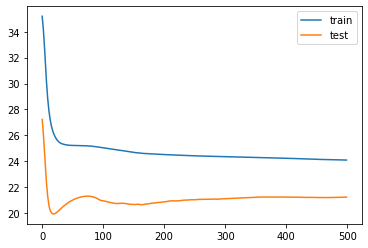

Test MAE: 21.028


In [17]:
scaler_sj, reframed_sj = normalize_and_reframe(sj_total)

train_sj_X, train_sj_y, test_sj_X, test_sj_y, prediccion_sj_X = split_and_reshape(reframed_sj, 0.85, sj_submission.shape[0])

model_sj = entrenar_modelo(train_sj_X, train_sj_y, test_sj_X, test_sj_y)

prediccion_test_sj = hacer_prediccion(model_sj, test_sj_X)

test_sj = evaluar( test_sj_y, prediccion_test_sj)

prediccion_submission_sj = hacer_prediccion(model_sj, prediccion_sj_X)



/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


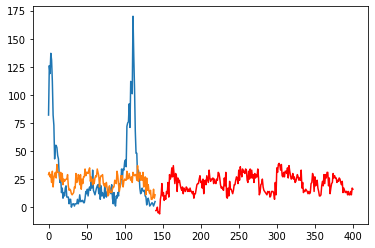

In [18]:
plt.plot(test_sj)
plt.plot(prediccion_test_sj)
plt.plot([None for i in test_sj] + [x for x in prediccion_submission_sj], color= "red" )
plt.show()


# IQUITOS

In [19]:
iq_train_date = quitar_fechas(iq_train_date)
iq_test_date = quitar_fechas(iq_submission)


In [20]:
#para que todas tengan el mismo scaler es necesario juntar ambos datasets, total_cases se queda fuera del scaler porque no tenemos todos los valores, se supone que esa acción no es muy perjudicial.
iq_total = pd.concat([iq_train_date,iq_test_date])
iq_total.reset_index(inplace = True, drop = True)

(442, 1, 31) (442,) (78, 1, 31) (78,) (156, 1, 31)
Epoch 1/500
7/7 - 2s - loss: 7.6277 - val_loss: 6.8598
Epoch 2/500
7/7 - 0s - loss: 7.4775 - val_loss: 6.6492
Epoch 3/500
7/7 - 0s - loss: 7.3184 - val_loss: 6.4175
Epoch 4/500
7/7 - 0s - loss: 7.1453 - val_loss: 6.1653
Epoch 5/500
7/7 - 0s - loss: 6.9733 - val_loss: 5.9482
Epoch 6/500
7/7 - 0s - loss: 6.8307 - val_loss: 5.7414
Epoch 7/500
7/7 - 0s - loss: 6.6906 - val_loss: 5.5444
Epoch 8/500
7/7 - 0s - loss: 6.5666 - val_loss: 5.3896
Epoch 9/500
7/7 - 0s - loss: 6.4689 - val_loss: 5.2648
Epoch 10/500
7/7 - 0s - loss: 6.3854 - val_loss: 5.1483
Epoch 11/500
7/7 - 0s - loss: 6.3144 - val_loss: 5.0439
Epoch 12/500
7/7 - 0s - loss: 6.2624 - val_loss: 4.9518
Epoch 13/500
7/7 - 0s - loss: 6.2238 - val_loss: 4.8793
Epoch 14/500
7/7 - 0s - loss: 6.1961 - val_loss: 4.8310
Epoch 15/500
7/7 - 0s - loss: 6.1745 - val_loss: 4.7990
Epoch 16/500
7/7 - 0s - loss: 6.1593 - val_loss: 4.7825
Epoch 17/500
7/7 - 0s - loss: 6.1491 - val_loss: 4.7720
Epoch 

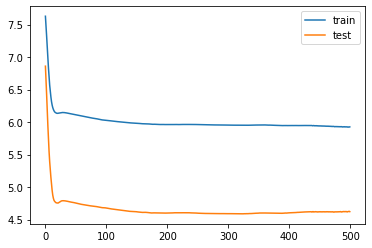

Test MAE: 4.526


In [21]:
scaler_iq, reframed_iq = normalize_and_reframe(iq_total)

train_iq_X, train_iq_y, test_iq_X, test_iq_y, prediccion_iq_X = split_and_reshape(reframed_iq, 0.85, iq_submission.shape[0])

model_iq = entrenar_modelo(train_iq_X, train_iq_y, test_iq_X, test_iq_y)

prediccion_test_iq = hacer_prediccion(model_iq, test_iq_X)

test_iq = evaluar( test_iq_y, prediccion_test_iq)

prediccion_submission_iq = hacer_prediccion(model_iq, prediccion_iq_X)



/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


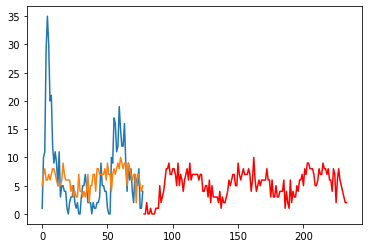

In [22]:
plt.plot(test_iq)
plt.plot(prediccion_test_iq)
plt.plot([None for i in test_iq] + [x for x in prediccion_submission_iq], color= "red" )
plt.show()


In [23]:
submission.total_cases = np.concatenate([prediccion_submission_sj, prediccion_submission_iq])

In [24]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

submission.to_csv("benchmark.csv")

Mounted at /content/gdrive
